threading (멀티스레딩): 하나의 프로세스 내에서 여러 개의 스레드를 실행합니다. 스레드들은 메모리를 공유하지만 , GIL 때문에 한 번에 하나의 스레드만 Python 바이트코드를 실행할 수 있습니다.

multiprocessing (멀티프로세싱): 여러 개의 독립적인 프로세스를 생성하여 실행합니다. 각 프로세스는 자신만의 메모리 공간과 Python 인터프리터를 갖기 때문에 GIL의 영향을 받지 않습니다. 따라서 여러 CPU 코어를 활용하여 실제 병렬 처리가 가능합니다.

이걸 간단한 torch network 로 multi ( ) learning 하도록 만들어봅시다

일단 데이터 준비

In [12]:
import torch
import torch.nn as nn
import time
import threading
import torch.multiprocessing as mp

# Colab에서 멀티프로세싱 사용 시, 'spawn' 시작 방식을 설정하는 것이 안정적입니다.
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 16, 5, 1, 2), nn.ReLU(), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2), nn.ReLU(), nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
    def forward(self, x):
        out = self.layer1(x); out = self.layer2(out)
        out = out.reshape(out.size(0), -1); out = self.fc(out)
        return out

# --- 비교 기준: 일반적인 방식 (배치를 나누지 않음) ---
print("--- 1. 기준 성능 측정 (일반적인 방식) ---")
batch_size = 1000
# batch_size = 32
# (batch_size, channels, height, width)
input_tensor = torch.randn(batch_size, 1, 28, 28)
model = SimpleCNN()

model.eval() # 추론 모드로 설정
with torch.no_grad(): # 그래디언트 계산 비활성화
    start_time = time.perf_counter()
    # 32개 샘플을 한 번에 처리
    output = model(input_tensor)
    end_time = time.perf_counter()

baseline_time = end_time - start_time
print(f"전체 배치(32개)를 한 번에 처리하는 데 걸린 시간: {baseline_time:.6f}초")
print("-" * 40)

--- 1. 기준 성능 측정 (일반적인 방식) ---
전체 배치(32개)를 한 번에 처리하는 데 걸린 시간: 0.670872초
----------------------------------------


In [13]:
# --- 2. multithreading으로 배치 처리 ---
print("\n--- 2. Multithreading 방식 (8개 x 4 스레드) ---")

# 각 스레드가 실행할 함수
def thread_worker(model, data_chunk, results, index):
    """모델과 데이터 조각을 받아 순방향 전파를 실행하고 결과를 저장"""
    with torch.no_grad():
        output = model(data_chunk)
        results[index] = output

# 데이터를 4개의 조각으로 나눔
chunks = torch.chunk(input_tensor, 4, dim=0)
threads = []
# 각 스레드의 결과를 저장할 리스트 (크기를 미리 할당)
results = [None] * 4

start_time = time.perf_counter()

for i in range(4):
    thread = threading.Thread(target=thread_worker, args=(model, chunks[i], results, i))
    threads.append(thread)
    thread.start()

# 모든 스레드가 끝날 때까지 대기
for thread in threads:
    thread.join()

# 조각난 결과들을 다시 하나로 합침
final_output = torch.cat(results, dim=0)
end_time = time.perf_counter()

threading_time = end_time - start_time
print(f"4개 스레드로 나누어 처리하는 데 걸린 시간: {threading_time:.6f}초")
print(f"결과 텐서 크기: {final_output.shape}")
print(f"속도 비교: 기준보다 x{threading_time / baseline_time:.2f}")
print("-" * 40)


--- 2. Multithreading 방식 (8개 x 4 스레드) ---
4개 스레드로 나누어 처리하는 데 걸린 시간: 0.338517초
결과 텐서 크기: torch.Size([1000, 10])
속도 비교: 기준보다 x0.50
----------------------------------------


multiprocessing



In [14]:
# --- 3. multiprocessing으로 배치 처리 ---
print("\n--- 3. Multiprocessing 방식 (8개 x 4 프로세스) ---")

# Pool의 각 워커 프로세스가 실행할 함수
# 전역(global)에 모델을 정의하거나, 함수 내에서 모델을 매번 생성해야 함
# 여기서는 간단하게 전역 모델을 사용
def process_worker(data_chunk):
    """데이터 조각을 받아 순방향 전파를 실행하고 결과를 반환"""
    # 이 예제는 CPU에서 실행됩니다.
    # 각 프로세스는 독립적이므로 model_cpu를 사용합니다.
    with torch.no_grad():
        return model_cpu(data_chunk)

if __name__ == '__main__':
    # 멀티프로세싱은 CPU에서 실행
    model_cpu = SimpleCNN().cpu()
    input_tensor_cpu = input_tensor.cpu()

    # 데이터를 4개의 조각으로 나눔
    chunks_cpu = torch.chunk(input_tensor_cpu, 4, dim=0)

    start_time = time.perf_counter()

    # 프로세스 풀(Pool)을 생성하여 작업을 분배
    with mp.Pool(processes=4) as pool:
        # map은 chunks_cpu의 각 요소를 process_worker 함수에 전달하고 결과를 리스트로 받음
        results = pool.map(process_worker, chunks_cpu)

    # 조각난 결과들을 다시 하나로 합침
    final_output_cpu = torch.cat(results, dim=0)
    end_time = time.perf_counter()

    processing_time = end_time - start_time
    print(f"4개 프로세스로 나누어 처리하는 데 걸린 시간: {processing_time:.6f}초")
    print(f"결과 텐서 크기: {final_output_cpu.shape}")
    print(f"속도 비교: 기준보다 약 {processing_time / baseline_time:.2f}배 느림")
    print("-" * 40)


--- 3. Multiprocessing 방식 (8개 x 4 프로세스) ---


KeyboardInterrupt: 

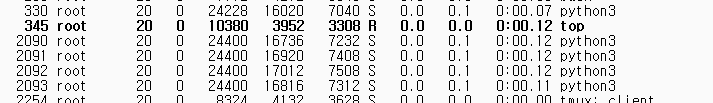

위 처럼 아예 프로세스가 여러개 생깁니다.

프로세스가 생긴다는건 다시 말해 메모리와 바이트코드를 복제해서 새롭게 프로그램을 만드는 것이므로 메인 프로세스에서 다른 프로세스들을 복사하고 그 결과를 가져오는데 오버헤드가 발생하게 됩니다.

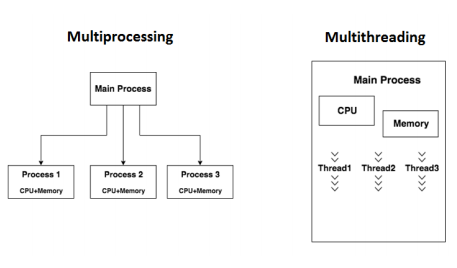

파이썬의 경우, GIL 때문에 각 스레드들을 만들더라도 한번에 하나씩만 실행되는 문제가 있습니다 (CPU를 여러 스레드에서 동시다발적으로 사용할 수 없습니다- 이를 동시성(concurrency)은 있지만 병렬성(parallelism)은 없다라고 합니다).

이 때문에 multiprocessing 을 씁니다만, 이 경우 CPU사용은 병렬적으로 처리된다는 장점이 있으나 메모리와 바이트코드 등 프로세스 자체를 복제하므로 오버헤드가 발생합니다.

그럼 어떡함?

Torch 의 DDP + torchrun 기능 쓰기

별도의 폴더에서 설명